# Meta-Net
### Code for MIDL 2024 Short Paper Meta-Learning for Segmentation of In Situ Hybridization Gene Expression Images (Brain Image Analysis Unit, RIKEN CBS)

## Import libraries

In [1]:
import logging
import os
import sys

import numpy as np
import torch

import monai
#from monai.networks.nets import UNet
from monai.utils import set_determinism
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose)
from monai.metrics import DiceMetric

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as tf
import torch.nn.functional as F

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


import time
from datetime import date
import re
import glob
import random
import numpy as np
import cv2

from PIL import Image
from skimage.exposure import match_histograms

from IPython.display import clear_output

import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (7,12)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from numpy.lib import recfunctions as rfn
import math

import importlib

/home/charissa/miniconda3/envs/monai-og/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


You are using the customized swin_unetr.
You are using the customized swin_unetr.


In [2]:
sys.path.append('/home/charissa/shimogori/shimogori_adult/segmentation/inference/')
from transform_patches_4inference_3d import transform_im_to_patch_size_3d, untransform_im_to_patch_size_3d
from ishloader_4inference_3d import apply_preprocessing_4inference_3d

import run_inference_and_vis_nolabels_3d
importlib.reload(run_inference_and_vis_nolabels_3d)
from run_inference_and_vis_nolabels_3d import inference_and_vis

ishDataset_flex ok


In [3]:
set_determinism(seed=0)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare input directories for loading the image, gt labels; and segmentations

### segmentation input directories

In [4]:
seg_iroot = '/disk/charissa/ISH_reg_pipeline/segs/P0_segs/'

seg_roots = []
seg_roots = sorted([seg_iroot+x+'/' for x in os.listdir(seg_iroot) if 'net' in x])

seg_paths_all = []
for y in range(len(seg_roots)):
    #seg_paths_all.extend(sorted([seg_roots[y]+x+'/' for x in os.listdir(seg_roots[y]) if '.txt' not in x and '20230816_charunet_3d_diceloss_epochs_800_fold_0' not in x]))
    seg_paths_all.extend(sorted([seg_roots[y]+x+'/' for x in os.listdir(seg_roots[y]) if '.txt' not in x]))
num_models = len(seg_paths_all)


print(f'seg_paths: {len(seg_roots), seg_roots[2]}')
print(f'num_models: {num_models}, {seg_paths_all[10]}')

seg_paths: (5, '/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/')
num_models: 25, /disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231115_swinunetr_3d_diceloss_epochs_300_fold_0/


### image, label input directories

In [6]:
cmps_w_segs = sorted([x for x in os.listdir(seg_paths_all[0])])
test_cmps = ['GPRIN3_P0_28-4','LRRN3_P0_184-2','MET_P0_O-6','MRGPRF_P0_257-2','NNAT_P0_88-8','FBXW7_P0_308-4']

cmps_w_segs = [x for x in cmps_w_segs if x not in test_cmps]
print(cmps_w_segs, len(cmps_w_segs))

image_root = '/disk/k_raid/DATA/SHIMOGORI_P0/data/image/'
image_paths_all = sorted([image_root+x+'/' for x in cmps_w_segs if os.path.exists(image_root+x)])
image_paths_all

label_paths_all = [x.replace('image','label') for x in image_paths_all]

print(image_paths_all[5], label_paths_all[5])

['ABCD2_P0_303-8', 'ADGRL4_P0_168-6', 'CRABP1_P0_181-3', 'EGR1_P0_R-1', 'GNG2_P0_339-1', 'NFKBIA_P0_201-4', 'PDE10A_P0_109-1', 'PPP1R16B_P0_77-3', 'SEC24D_P0_267-3', 'TSPYL2_P0_49-6'] 10
/disk/k_raid/DATA/SHIMOGORI_P0/data/image/NFKBIA_P0_201-4/ /disk/k_raid/DATA/SHIMOGORI_P0/data/label/NFKBIA_P0_201-4/


### split the training images and labels into 7:3 train:val subsets

In [8]:
import math
splitter = math.floor(len(image_paths_all)*.7)
#print(splitter)

train_images = image_paths_all[:splitter]
train_labels = label_paths_all[:splitter]
val_images = image_paths_all[splitter:]
val_labels = label_paths_all[splitter:]

assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)
print(len(train_images), len(val_images))

7 3


### ishDataset class

In [ ]:
#%% class ishDataset, char edit
class ishDataset_flex_wnames(Dataset):
    
    def __init__(self, image_ls: list, label_ls: list, im_names_ls: list):
        self.image_ls = image_ls
        self.label_ls = label_ls
        self.name_ls = im_names_ls

    def __getitem__(self, idx):
        image, label, name = self.image_ls[idx], self.label_ls[idx], self.name_ls[idx]

        return image, label, name
    
                
    def __len__(self):
        return len(self.image_ls)
    
        
print("ok")

## image, label transforms

In [ ]:
tt = transforms.ToTensor()
augm_transforms = transforms.Compose([transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.1)], p=0.8),
                                      transforms.GaussianBlur(kernel_size=3),
                                    ])

from skimage.transform import resize

# Load the images/labels as stacked arrays
def load_stack_names(image_dir, label_dir):
    label_f = sorted(glob.glob(label_dir+'/*.png'))
    image_f = sorted(glob.glob(image_dir+'/*.png'))
    
   
    #########################################
    assert(len(image_f)==len(label_f))
    
    print(f'num files:  images {len(image_f)}  labels {len(label_f)}')
    
    for idx in range(len(image_f)): 
        try:
            assert(image_f[idx].split('/')[-2] == image_f[0].split('/')[-2])
        except:
            print(f'assertion error: {image_f[idx]} and {image_f[0]}')
        try:
            assert(image_f[idx].split('/')[-2] == label_f[0].split('/')[-2])
        except:
            print(f'assertion error: {image_f[idx]} and {label_f[0]}')
        
        image = np.asarray(Image.open(image_f[idx]))  # (1440, 1680, 3)
        label = np.asarray(Image.open(label_f[idx]))


        # split in half, vertically
        half = int(image.shape[1]//2)
        image = image[:,half:,:]
        if len(label.shape) > 2:
            label = label[:,half:,:]
        else:
            label = label[:,half:]

        image = resize(image, (256, 128, image.shape[2]))
        label = resize(label, (256, 128))  


        # 2ch: this was 1 channel, 0=bg 1=signal no go bc monai loss function needs one-hot
        if True:  # if label has a channel channel
            if len(label.shape) > 2:
                newlabel = np.zeros((label[:,:,1].shape))
                newlabel[label[:,:,1] > 0.1] = 1
                label = newlabel
                assert(len(np.unique(label)) <= 3)
            else:  # if label does not have a channel channel
                if len(np.unique(label)) > 2:
                    newlabel = np.zeros((label.shape))
                    #print(label.shape, label.max())
                    newlabel[label>0.1] = 1
                    label = newlabel
                assert(len(np.unique(label)) <= 2)

        
        image = tt(image)  # torch.Size([3, 1440, 1680])
        label = tt(label)
        
       
        if idx == 0:
            image_np = np.zeros((len(image_f), image.shape[0],image.shape[1],image.shape[2]), dtype='float32')
            label_np = torch.zeros((len(image_f), label.shape[0],label.shape[1],label.shape[2]), dtype=torch.float32)
            
    
        image_np[idx,...] = image
        label_np[idx,...] = label


        assert(len(image_np) == len(label_np))

    
    return image_np, label_np, image_f, label_f

    
# Histogram matching using a sliding window of 9    
def histogram_matching(image_stack, train_with_transforms_flag, ministack_size=9):  
    buffer = math.floor(ministack_size/2)

    counter=0

    matched_np = np.copy(image_stack)

    if train_with_transforms_flag:
        for idx in range(image_stack.shape[0]):
            
            # if the section-of-interest in v anterior, then the sliding window is left-smushed
            if idx-buffer < 0:
                start = 0
                this = idx
            else:
                start = idx-buffer
                this = 4

            # if the section-of-interest is v posterior, then the sliding window is right-smushed
            if start+ministack_size > image_stack.shape[0]:
                counter = counter+1
                this = buffer+counter  # this is the center image in the ministack, i.e. the section-of-interest
                start = image_stack.shape[0] - ministack_size
    

            ministack = image_stack[start:start+ministack_size,...]
                   
            
            try:
                assert(ministack.shape[0] == ministack_size)
            except:
                print(f'ministack shape: {ministack.shape}  {ministack_size}')
    
            ministack_median = np.median(ministack, axis=0)

            matched = match_histograms(ministack[this,...], ministack_median, channel_axis=1)  # -1
    
            matched_np[idx,...] = matched

            # visualization
            if False:
                print(f'in histogram matching, start: {start}, this: {this}')
                for z in range(ministack.shape[0]):
                    plt.subplot(1,ministack.shape[0]+2,z+1)
                    if z == 0:    
                        plt.imshow(np.transpose(image_stack[idx,:,:,:],(1,2,0)))
                        plt.title('image '+str(idx))
                        plt.axis('off')
                    else:
                        plt.imshow(np.transpose(ministack[z-1,...], (1,2,0)))
                        plt.title('ministack '+str(z-1))
                        plt.axis('off')
                plt.show()
                
            

    matched_np = np.transpose(matched_np, (0,2,3,1))  # has to be in  (H x W x C) 
    print(f'in histogram_matching, after transpose matched_np: {matched_np.shape}')   #  (10, 720, 420, 3)
    
    matched_torch = torch.zeros((matched_np.shape[0], matched_np.shape[-1], matched_np.shape[1], matched_np.shape[2]))


    for i in range(matched_np.shape[0]):
        matched_torch[i,...] = tt(matched_np[i,...])
    
    return matched_torch  # torch.Size([60, 3, 720, 420]), (60, 3, 1440, 840)


# snd image and label stacks to augm_transforms    
def trafo(image_stack, label_stack, train_with_transforms_flag): 
    if train_with_transforms_flag:
        image_stack = augm_transforms(image_stack)


    return image_stack, label_stack




In [ ]:
plt.rcParams["figure.figsize"] = (15,5)

if False:
    train_images_list_all = []
    train_labels_list_all = []
    train_images_names_all = []
    train_labels_names_all = []
    
    train_with_transforms_flag = True
    
    for i in range(len(train_images)):  # list of list of cmps
        train_images_1fold=[]
        train_labels_1fold=[]
        image_np, label_np, train_image_names, train_label_names = load_stack_names(train_images[i], train_labels[i]) #image: (60, 1440, 840, 3), label: torch.Size([60, 3, 1440, 840])
        

        #print(image_np.shape, image_np.dtype, label_np.shape, label_np.dtype)
        #(10, 3, 720, 420) float32 torch.Size([10, 1, 720, 420]) torch.float32
        print(f'post LOAD_STACK_NAMES, {image_np.shape, label_np.shape}')
        if False:
            plt.subplot(1,3,1)
            plt.imshow(np.transpose(image_np[3,...],(1,2,0)))
            plt.title(train_image_names[3].split('/')[-1])
            plt.subplot(1,3,2)
            plt.imshow(label_np[3,0,...])
            plt.title(train_label_names[3].split('/')[-1])
            plt.subplot(1,3,3)
            plt.imshow(np.transpose(image_np[3,...],(1,2,0)))
            plt.imshow(label_np[3,0,...], alpha=0.2)
            plt.show()
        
        
        if train_with_transforms_flag:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=True)  # torch.Size([60, 3, 1440, 840])
        else:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=False)
        
        
        print(f'post HISTOGRAM_MATCHING, {new_image_np.shape, label_np.shape}')
        if False:
            #print(new_image_np.shape, new_image_np.dtype, label_np.shape)
            #torch.Size([10, 3, 720, 420]) torch.Size([10, 1, 720, 420])
            plt.subplot(1,5,1)
            plt.imshow(torch.permute(new_image_np[3,...],(1,2,0)))
            plt.title(train_image_names[3].split('/')[-1])
            plt.subplot(1,5,2)
            plt.imshow(label_np[3,0,:,:])
            plt.title(train_label_names[3].split('/')[-1])
            plt.subplot(1,5,3)  # same as above
            plt.imshow(torch.permute(new_image_np[3,...],(1,2,0)))
            plt.imshow(label_np[3,0,:,:], alpha=0.2)
            plt.subplot(1,5,4)  # same as above
            plt.imshow(np.transpose(image_np[3,...],(1,2,0)))
            plt.imshow(label_np[3,0,:,:], alpha=0.2)
            plt.title('pre')
            plt.subplot(1,5,5)  # same as above
            plt.imshow(torch.permute(new_image_np[3,...],(1,2,0)))
            plt.imshow(label_np[3,0,:,:], alpha=0.2)
            plt.title('post')
            plt.show()
                    
        assert(len(new_image_np) == len(label_np))

        print(f'new_image_np: {new_image_np.shape}, label_np: {label_np.shape}')
        train_images_list_all.extend(new_image_np)
        train_labels_list_all.extend(label_np)
        train_images_names_all.extend(train_image_names)
        train_labels_names_all.extend(train_label_names)
        assert(len(train_images_list_all) == len(train_labels_list_all))
        assert(len(train_images_list_all) == len(train_images_names_all))

        del new_image_np, image_np, label_np, train_image_names, train_label_names
    
    print(f'images: {len(train_images_list_all)}, labels: {len(train_labels_list_all)}')

if True:
    val_images_list_all = []
    val_labels_list_all = []
    val_images_names_all = []
    val_labels_names_all = []
        
    train_with_transforms_flag = True
    
    for i in range(len(val_images)):  # list of list of cmps
        val_images_1fold=[]
        val_labels_1fold=[]
        image_np, label_np, val_image_names, val_label_names = load_stack_names(val_images[i], val_labels[i]) #image: (60, 1440, 840, 3), label: torch.Size([60, 3, 1440, 840])
    
        if train_with_transforms_flag:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=True)  # torch.Size([60, 3, 1440, 840])
        else:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=False)
            
        assert(len(new_image_np) == len(label_np))
      
        val_images_list_all.extend(new_image_np)
        val_labels_list_all.extend(label_np)
        val_images_names_all.extend(val_image_names)
        val_labels_names_all.extend(val_label_names)
        assert(len(val_images_list_all) == len(val_labels_list_all))
        assert(len(val_images_list_all) == len(val_labels_names_all))
    
    print(f'images: {len(val_images_list_all)}, labels: {len(val_labels_list_all)}')

## Dataset and Dataloaders

In [ ]:
train_dataset = ishDataset_flex_wnames(train_images_list_all, train_labels_list_all, train_images_names_all)
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=10)

val_dataset = ishDataset_flex_wnames(val_images_list_all, val_labels_list_all, val_images_names_all)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=10)


## Helper functions - find and load the relevant segmentations for a given image

In [9]:
ttt = transforms.ToTensor()

def find_segs(name, seg_paths_all):
    """
    name is from n[0]    
    """

    # 1 find the P0 cmp and corresponding z
    cmp = [x for x in name.split('/') if 'P0_' in x][0]
    z = [x for x in name.split('/') if '.png' in x][0]
    print(f'cmp: {cmp}, z: {z}')
    
    # 2 find the p0 cmp's matching segmentation dirs
    if cmp in [x for x in os.listdir(seg_paths_all[0])]:  # does not matter what the index of seg_paths_all should be
        seg_idirs_4_cmp_z = []
        for i in seg_paths_all: 
            if os.path.exists(i+cmp):
                #seg_idir = i+p0_id+'/'
                seg_dir = i+cmp+'/'+z
                seg_idirs_4_cmp_z.append(seg_dir)
            else:
                print(f'no matching seg idir for {i} and {cmp}')
    else:
        print(f'no {cmp} in segmentations {os.listdir(seg_paths_all[0])}')
        
    #print(f'number of segmentations + eg: {len(seg_idirs_4_cmp_z)}\n{seg_idirs_4_cmp_z[2]}\n{seg_idirs_4_cmp_z[6]}')

    return seg_idirs_4_cmp_z
    
        
def load_segs(seg_idirs_4_cmp_z):
    # 3 load the relevant SEGS #
    for k in range(len(seg_idirs_4_cmp_z)):
        
        seg = np.asarray(Image.open(seg_idirs_4_cmp_z[k]))
        half = int(seg.shape[1]/2)
        seg = seg[:,half:]
    
        # downsize the segmentations as the images and labels were downsized
        #seg = resize(seg, (1024, 512))
        #seg = resize(seg, (512, 256))
        seg = resize(seg, (256, 128))
        
        seg = seg.astype('float32')
        seg /= 255
    
        # ensure that seg.max() == 1 if there is something in the image
        #if seg.max() > 0.3:
        #    seg = seg*1/seg.max()
    
        seg = ttt(seg)
        
        if k==0:
            seg_all = torch.zeros((len(seg_idirs_4_cmp_z), seg.shape[1], seg.shape[2]))

        seg_all[k] = seg[0]
        
        #print(seg.dtype, seg.max(), seg.shape)#, np.unique(seg))
    if seg_all.max() < 0.999:
        seg_all = seg_all*1/seg_all.max()
    seg_all = torch.unsqueeze(seg_all, dim=0)
    seg_all = seg_all.to(device)
    # seg_all: torch.Size([1, 25, 1024, 512]

    #del seg_idirs_4_cmp_z

    return seg_all
    
    ####################################

## Helper functions - plotting

In [ ]:
#plt.rcParams["figure.figsize"] = (20,6)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
def plot_x_y_yhat_preds(x,y,yhat,pred_all_stack, epoch, vis_out):

    # for naming
    if epoch < 10:
        str_epoch = '_epoch00'+str(epoch)
    elif epoch < 100:
        str_epoch = '_epoch0'+str(epoch)
    else:
        str_epoch = '_epoch'+str(epoch)        

    num_rows = 1
    num_cols = pred_all_stack.shape[1]+3
    
    fig, axs = plt.subplots(num_rows,num_cols, figsize=(20,6))
    
    for i in range(pred_all_stack.shape[1]+3):    
        if i==0:
            axs[i].imshow(torch.permute(x[0,...],(1,2,0)).clone().cpu().detach().numpy())
            axs[i].title.set_text('x')
        elif i==1:
            axs[i].imshow(y[0,0,...].clone().cpu().detach().numpy())
            axs[i].title.set_text('y')
        elif i==2:
            axs[i].imshow(yhat[0,0].clone().cpu().detach().numpy())
            axs[i].title.set_text('yhat')
        else:
            axs[i].imshow(pred_all_stack[0,i-3,...].clone().cpu().detach().numpy())
            axs[i].title.set_text('pred'+str(i))
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(vis_out+str_epoch+'_xyyhatpreds.png')
    
    # plt.show()

In [ ]:
def plot_all_segs_weights(seg_all, out_name, save_flag=False):
    """
    input examples:
    meta_weights: torch.Size([1, 25, 256, 128]), 
    original_segmentation_masks: torch.Size([1, 25, 256, 128])
    """

    
    nrows = ncols = 5
    fig, axs = plt.subplots(nrows,ncols, figsize=(10,20))
    
    for i in range(seg_all.shape[1]):    
        for j in range(ncols):
            for k in range(nrows):
                axs[j,k].imshow(seg_all[0,i,:,:].detach().cpu(), vmin=0, vmax=1)
                axs[j,k].axis('off')
                axs[j,k].title.set_text(str(i))
    fig.tight_layout()

    if save_flag:
        plt.savefig(out_name)
    #else:
    #    fig.show()


## Meta-Net

In [ ]:
def convbnrelu_im_33(in_channels, out_channels):
    return nn.Sequential(
        #nn.Conv3d(in_channels, out_channels, kernel_size=(3,3,3), stride=(1,1,1), padding='same'),
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        #nn.Tanh(),
    )

In [ ]:
import torch.nn.functional as F

class Meta_Unet(nn.Module):
    def __init__(self, im_shape, num_models, init_features=16):  # in_channels=11, 
        super(Meta_Unet, self).__init__()

        self.im_shape = im_shape
        self.num_models = num_models
        
        if len(self.im_shape) == 2:
            self.im_size = self.im_shape[0] * self.im_shape[1]
        elif len(self.im_shape) == 3:
            self.im_size = self.im_shape[0] * self.im_shape[1] * self.im_shape[2]
        elif len(self.im_shape) == 4:
            self.im_size = self.im_shape[0] * self.im_shape[1] * self.im_shape[2] * self.im_shape[3]
        else:
            print('error')
    
        self.in_channels = num_models + 1  # add 1 channel for the image
        self.hidden_size = 128

        self.device = device

        self.conv2d_im = nn.Conv2d(3, 1, kernel_size=(3,3), stride=(1,1), padding=(1,1))  # reduce 3 ch in im to 1 ch


        ## ENCODER
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv_down1 = convbnrelu_im_33(self.in_channels, init_features)
        self.conv_down2 = convbnrelu_im_33(init_features, init_features*2)
        self.conv_down3 = convbnrelu_im_33(init_features*2, init_features*4)
        self.conv_down4 = convbnrelu_im_33(init_features*4, init_features*8)
        self.bottleneck = convbnrelu_im_33(init_features*8, init_features*16)

        ## DECODER
        self.convT4 = nn.ConvTranspose2d(init_features*16, init_features*8, kernel_size=(2,2), stride=(2,2))##bn this
        self.conv_up4 = convbnrelu_im_33((init_features*8)*2, init_features*8)
        self.convT3 = nn.ConvTranspose2d(init_features*8, init_features*4, kernel_size=(2,2), stride=(2,2))##bn this
        self.conv_up3 = convbnrelu_im_33((init_features*4)*2, init_features*4)
        self.convT2 = nn.ConvTranspose2d(init_features*4, init_features*2, kernel_size=(2,2), stride=(2,2))##bn this
        self.conv_up2 = convbnrelu_im_33((init_features*2)*2, init_features*2)
        self.convT1 = nn.ConvTranspose2d(init_features*2, init_features, kernel_size=(2,2), stride=(2,2))##bn this
        self.conv_up1 = convbnrelu_im_33(init_features*2, init_features)
        self.conv_up0 = convbnrelu_im_33(init_features, self.in_channels)

        ## henrik edit
        self.conv2d_out = nn.Conv2d(self.in_channels, self.in_channels, kernel_size=(1,1), stride=(1,1), padding=(0,0))
        


    def forward(self, x, yhat_all):

        ## PREPARE IMAGE AND SEGS
        # reduce x from 3,512,512 to 1,512,512 which matches preds
        x = self.conv2d_im(x)

        # concat x and preds stack
        x_preds = torch.cat((x, yhat_all), dim=1)

        
        ## ENCODE    
        # values for 3,512,512 im input and 1,512,512 preds                                                   
        enc1 = self.conv_down1(x_preds)               # torch.Size([1, 16, 512, 512])
        enc2 = self.conv_down2(self.maxpool(enc1))    # torch.Size([1, 32, 256, 256])
        enc3 = self.conv_down3(self.maxpool(enc2))    # torch.Size([1, 64, 128, 128])
        enc4 = self.conv_down4(self.maxpool(enc3))    # torch.Size([1, 128, 64, 64])
        
        bottle = self.bottleneck(self.maxpool(enc4))  # torch.Size([1, 256, 32, 32])
        


        ## DECODE
        dec4 = self.convT4(bottle)  
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv_up4(dec4)       
        
        dec3 = self.convT3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv_up3(dec3)                     # torch.Size([1, 64, 128, 128])
        
        dec2 = self.convT2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv_up2(dec2)                     # torch.Size([1, 32, 256, 256])
        
        dec1 = self.convT1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv_up1(dec1)                     # torch.Size([1, 16, 512, 512])
        
        out = self.conv_up0(dec1)                      # torch.Size([1, 11, 512, 512])
        

        ## henrik edits
        original_segmentation_masks = yhat_all
        network_outputs = self.conv2d_out(out)
        meta_weights = torch.nn.functional.softmax(network_outputs,dim=1)   #meta_weights: torch.Size([1, 26, 256, 128])
        meta_weights = meta_weights[:,1:,:,:]   # remove image from calculating the meta-segmentation

        
        meta_out = torch.sum(meta_weights*original_segmentation_masks,dim=1,keepdim=True)        
        
        
        return meta_out, meta_weights




## Train_one_epoch and early stopper

In [ ]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_one_epoch(epoch_index, loss_function, vis_opath, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # use enumerate(train_loader) instead of iter(train_loader) to keep track of the batch index
    # and do some intra-epoch reporting

    for i, data in enumerate(train_loader):
        x, y, n = data
        x = x.to(device)
        y = y.to(device)
        
        ########### find the segs ###########
        seg_idirs = find_segs(n[0], seg_paths_all)
        seg_all = load_segs(seg_idirs)
        #####################################

        # zero your gradients for every batch
        optimizer.zero_grad()

        yhat, yhat_weights = meta_model(x, seg_all)
        #yhat = meta_model(x, seg_all)

        loss = loss_function(yhat, y)
        #print(f'epoch: {epoch_index}, loss: {loss.item()}')
        loss.backward()

        # adjust learning weights
        optimizer.step()

        # gather data, report
        running_loss += loss.item()

        if i % 100 == 99:
            last_loss = running_loss / 100  # loss per batch, even though batch size is not 100...? was 4 in the hp
            #print('     batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index + len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

        if False:
            if (epoch_index+1) % 10 == 9:
                print(f'plotting x/y/yhat/preds, segs, and weights at epoch {epoch_index} \nx: {x.shape}, y: {y.shape}, yhat: {yhat.shape}, seg_all: {seg_all.shape}')
                #print('plotting x, y, yhat, and preds')
                #plot_x_y_yhat_preds(x,y,yhat,seg_all, epoch_index, vis_opath)
        
                # create naming for vis outputs
                if epoch_index < 10:
                    str_epoch = '00'+str(epoch_index)
                elif epoch_index < 100:
                    str_epoch = '0'+str(epoch_index)        
                else:
                    str_epoch = str(epoch_index)                
        
                sout_name = vis_opath+'_epoch_'+str(epoch_index)+'_all_segs.png'
                wout_name = vis_opath+'_epoch_'+str(epoch_index)+'_all_weights.png'
    
                print('plotting all segs')
                plot_all_segs_weights(seg_all, sout_name, save_flag=True)
                print('plotting all weights')
                plot_all_segs_weights(yhat_weights, wout_name, save_flag=True)

    return last_loss

In [ ]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


## Training

In [ ]:
loss_function = DiceLoss(sigmoid=False, include_background=True)  # x: ff ; o: ft
ttt = transforms.ToTensor()

# detaches the gradient for some reason
post_pred = Compose([Activations(sigmoid=False), AsDiscrete(threshold=0.5005)])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
metric_values = []
loss_values = []

max_epochs = 100
best_metric = -1
val_interval = 1


weights_ls = []
val_weights_ls = []
train_loss_ls = []
val_loss_ls = []
val_metric_ls = []

# set up naming for the saved models
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print("timestamp:", timestamp)

workdir = '/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/runs/'
last_model_path = workdir+timestamp+'_256128_meta_unet_lastmodel.pth'

writer = SummaryWriter(workdir+'test_{}'.format(timestamp))

with open(last_model_path.replace('lastmodel.pth','0notes.txt'),'w') as f:
    f.write('with henrik edits , segmentations not images used to calculate final master meta segmentation')
f.close()


##### create vis_odir #####
vis_odir = workdir.replace('/runs/','/vis/')
os.makedirs(vis_odir, exist_ok=True)
vis_opath = vis_odir+timestamp


##### initialize the model #####
x,y,n = next(iter(train_loader))
meta_model = Meta_Unet(x.shape, num_models)
meta_model = meta_model.to(device)

optimizer = torch.optim.Adam(meta_model.parameters(), 1e-3)


# initialize early stopper
early_stopper = EarlyStopper(patience=3, min_delta=.04)



for epoch in range(max_epochs):

        print(f'{epoch}/{max_epochs}')

        meta_model.train(True)
        avg_loss = train_one_epoch(epoch, loss_function, vis_opath, writer)
        print(f'{epoch}/{max_epochs}: {avg_loss}')
        train_loss_ls.append([epoch, avg_loss])
        #clear_output(wait=True)

        
        if (epoch + 1) % val_interval == 0:
            running_vloss = 0.
            
            # Set the model to evaluation mode, disabling dropout and using population
            # statistics for batch normalization.
            meta_model.eval()
            
            with torch.no_grad():
                count = 0
                ### for validation data to test on unseen data ###
                val_x = None
                val_y = None
                
                #for val_data in val_loader:
                for i, val_data in enumerate(val_loader):

                    # forward pass
                    val_x, val_y, val_n = val_data[0].to(device), val_data[1].to(device), val_data[2]
                    # x: torch.Size([1, 3, 1024, 512]
                    # y: torch.Size([1, 1, 1024, 512]
                    
                    
                    ########### find the segs ###########
                    val_seg_idirs = find_segs(val_n[0], seg_paths_all)
                    val_seg_all = load_segs(val_seg_idirs)
                    ####################################

                    
                        
                    val_yhat, val_yhat_weights = meta_model(val_x, val_seg_all)
                    vloss = loss_function(val_yhat, val_y)
                    running_vloss += vloss.item()

                        
                    val_yhat = post_pred(val_yhat)

                    dice_metric(y_pred=val_yhat, y=val_y)   

                    
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()

                # reset the status for next validation round
                val_metric_ls.append([epoch, metric])
                dice_metric.reset()

                metric_values.append([epoch, metric])
                print(f'epoch: {epoch}, metric: {metric}')

                
                if (epoch+1) % 10 == 0:
                    plot_x_y_yhat_preds(val_x, val_y, val_yhat, val_seg_all, epoch, vis_opath)
                
                count += 1
                
                 # plot
                if True:
                    if epoch < 10:
                        str_epoch = '00' + str(epoch)
                    elif epoch < 100:
                        str_epoch = '0' + str(epoch)
                    plt.subplot(1,3,1)
                    plt.imshow(val_x[0,0].cpu().detach().numpy())
                    plt.title('x')
                    plt.subplot(1,3,2)
                    plt.imshow(val_yhat[0,0].cpu().detach().numpy())
                    plt.title('yhat')
                    plt.subplot(1,3,3)
                    plt.imshow(val_y[0,0].cpu().detach().numpy())
                    plt.title('y')
                    plt.savefig(vis_opath+str_epoch+'.png')
                    plt.show()

                del val_seg_all

                avg_vloss = running_vloss / (i+1)
                print('LOSS train {} val {}'.format(avg_loss, avg_vloss))
                val_loss_ls.append([epoch, avg_vloss])

                # early stopper
                if early_stopper.early_stop(avg_vloss):             
                    break

                # log the running loss averaged per batch for both training and validation
                writer.add_scalars('train vs validation loss',
                                  {'train': avg_loss, 'val': avg_vloss},
                                   epoch +1)
                writer.flush()
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_model_path = '{}_{}_256128_bestmodel.pth'.format(workdir,timestamp)
                    #torch.save(meta_model.state_dict(), best_model_path)
                    state = {'epoch' : epoch+1, 'state_dict' : meta_model.state_dict(), 'optimizer' : optimizer.state_dict()}
                    torch.save(state, best_model_path)
                    
                    print("current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(epoch + 1, metric, best_metric, best_metric_epoch))
                    print(f"model saved at {best_model_path}")

            #clear_output(wait=True)

        # just in case, write the train loss, val loss, and val metric
        with open(workdir+timestamp+'0_train_loss.txt','w') as f:
            for line in train_loss_ls:
                f.write(f'{line}\n')   

        with open(workdir+timestamp+'0_val_loss.txt','w') as g:
            for line in val_loss_ls:
                g.write(f'{line}\n')   

        with open(workdir+timestamp+'0_val_metric.txt','w') as h:
            for line in metric_values:
                h.write(f'{line}\n')   

#torch.save(meta_model.state_dict(), last_model_path)
state = {'epoch' : epoch+1, 'state_dict' : meta_model.state_dict(), 'optimizer' : optimizer.state_dict()}
torch.save(state, last_model_path)
print(f'------ done at epoch {epoch}, saved last model as {last_model_path}')

In [ ]:
"""
reloading state_dict from checkpoints

x,y,n = next(iter(train_loader))
temp_model = Meta_Unet(x.shape, num_models)  # im_shape, num_models, device
temp_model = temp_model.to(device)

check = torch.load(last_model_path)

temp_model.load_state_dict(check['state_dict'])
optimizer.load_state_dict(check['optimizer'])
"""

## Inference

### Prepare test images and labels

In [10]:
test_images = ['/disk/k_raid/DATA/SHIMOGORI_P0/data/image/FBXW7_P0_308-4/',
'/disk/k_raid/DATA/SHIMOGORI_P0/data/image/GPRIN3_P0_28-4/',
'/disk/k_raid/DATA/SHIMOGORI_P0/data/image/LRRN3_P0_184-2/',
'/disk/k_raid/DATA/SHIMOGORI_P0/data/image/MET_P0_O-6/',
'/disk/k_raid/DATA/SHIMOGORI_P0/data/image/MRGPRF_P0_257-2/',
'/disk/k_raid/DATA/SHIMOGORI_P0/data/image/NNAT_P0_88-8/',]

test_labels = [x.replace('/image/','/label/') for x in test_images]

In [ ]:
if True:
    test_images_list_all = []
    test_labels_list_all = []
    test_images_names_all = []
    test_labels_names_all = []
        
    test_with_transforms_flag = True
    
    for i in range(len(test_images)):  # list of list of cmps
        test_images_1fold=[]
        test_labels_1fold=[]
        image_np, label_np, test_image_names, test_label_names = load_stack_names(test_images[i], test_labels[i]) #image: (60, 1440, 840, 3), label: torch.Size([60, 3, 1440, 840])
    
        if test_with_transforms_flag:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=True)  # torch.Size([60, 3, 1440, 840])
        else:
            new_image_np = histogram_matching(image_np, train_with_transforms_flag=False)
            
        assert(len(new_image_np) == len(label_np))

        
        test_images_list_all.extend(new_image_np)
        test_labels_list_all.extend(label_np)
        test_images_names_all.extend(test_image_names)
        test_labels_names_all.extend(test_label_names)
        assert(len(test_images_list_all) == len(test_labels_list_all))
        assert(len(test_images_list_all) == len(test_labels_names_all))
    
    print(f'images: {len(test_images_list_all)}, labels: {len(test_labels_list_all)}')

### Visualize images and labels from test_loader

In [ ]:
test_dataset = ishDataset_flex_wnames(test_images_list_all, test_labels_list_all, test_images_names_all)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=10)

In [ ]:
x,y,n = next(iter(test_loader))

print(x.shape, y.shape, n)
plt.subplot(1,2,1)
plt.imshow(torch.permute(x[0],(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(torch.permute(y[0],(1,2,0)))
plt.title(n[0])
plt.tight_layout()
plt.show()

In [ ]:
import sys
import importlib

sys.path.append('/home/charissa/shimogori/shimogori_adult/evaluation/code/')
import mydice

importlib.reload(mydice)

In [ ]:
x,y,n = next(iter(test_loader))

meta_model = Meta_Unet(x.shape, num_models)  # im_shape, num_models, device
meta_model = meta_model.to(device)

# if loading a trained model
best_model_path = '/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/runs/_20240314_230304_256128_bestmodel.pth'
check = torch.load(best_model_path, map_location=torch.device('cpu'))

meta_model.load_state_dict(check['state_dict'])


In [ ]:
from skimage.filters import threshold_otsu
from sklearn.metrics import precision_recall_fscore_support

plt.rcParams["figure.figsize"] = (12,8)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

counter = 0

# prepare lists to save the metrics
if True:  
    dice_meta_ls = []
    dice_sumpreds_ls = []
    #dice_single_ls = []
    dice_single_np = np.zeros((len(test_loader), num_models))  # (355, torch.Size([25]))
    p_metavsgt_avg_ls = []
    r_metavsgt_avg_ls = []
    f_metavsgt_avg_ls = []
    s_metavsgt_avg_ls = []
    p_metavsgt_max_ls = []
    r_metavsgt_max_ls = []
    f_metavsgt_max_ls = []
    s_metavsgt_max_ls = []
    p_metavsgt_min_ls = []
    r_metavsgt_min_ls = []
    f_metavsgt_min_ls = []
    s_metavsgt_min_ls = []
    
    p_sumpredsvsgt_avg_ls = []
    r_sumpredsvsgt_avg_ls = []
    f_sumpredsvsgt_avg_ls = []
    s_sumpredsvsgt_avg_ls = []
    p_sumpredsvsgt_max_ls = []
    r_sumpredsvsgt_max_ls = []
    f_sumpredsvsgt_max_ls = []
    s_sumpredsvsgt_max_ls = []
    p_sumpredsvsgt_min_ls = []
    r_sumpredsvsgt_min_ls = []
    f_sumpredsvsgt_min_ls = []
    s_sumpredsvsgt_min_ls = []


    ## set up np array for storing the dice of single model predictions ##
    data = next(iter(test_loader))
    x,y,n = data[0].to(device), data[1].to(device), data[2]
    
    ########### find the segs ###########
    seg_idirs = find_segs(n[0], seg_paths_all)
    seg_all = load_segs(seg_idirs)
    ######################################################################



post_pred = Compose([Activations(sigmoid=False), AsDiscrete(threshold=0.5005)])


for d, data in enumerate(test_loader):

    x,y,n = data[0].to(device), data[1].to(device), data[2]
    
    ########### find the segs ###########
    seg_idirs = find_segs(n[0], seg_paths_all)
    seg_all = load_segs(seg_idirs)              # (torch.Size([1, 25, 256, 128]), torch.float32)
    ####################################
    
    ##### run meta_unet #####
    yhat, yhat_weights = meta_model(x, seg_all)
    
    ##### make numpy versions, ensure shapes, dtypes, are the same #####
    y_np = torch.squeeze(y.detach().cpu()).numpy()
    yhat_np = torch.squeeze(yhat.detach().cpu()).numpy()
    
    
    # threshold, done on numpys
    thresh_meta = threshold_otsu(yhat_np)
    yhat_np = (yhat_np > thresh_meta)*1
    yhat_np = yhat_np.astype(np.float32)
    
    
    ##### make sum of all preds #####
    # all_preds should be tensor of form e.g. torch.Size([1, 25, 512, 512])
    preds_sum = torch.zeros((seg_all[0,0].shape))
    for i in range(seg_all.shape[1]):
        preds_sum += seg_all.detach().cpu()[0,i]
    preds_sum /= seg_all.shape[1]
    # threshold, done on numpys
    thresh_sum = threshold_otsu(preds_sum.numpy())
    preds_sum_01 = (preds_sum > thresh_sum)*1
    preds_sum_01 = preds_sum_01.type(torch.float32)  # has to be kept a Tensor for dice calculation
    preds_sum_01_np = preds_sum_01.detach().cpu().numpy()
    
    # save preds
    yhat_np_int = yhat_np.astype(np.uint8)*255
    pred_meta = Image.fromarray(yhat_np_int)
    #pred_meta.save('/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/out/20240403_nonew_testset_metanet/'+n[0].split('/')[-2]+'_'+n[0].split('/')[-1])
    
    preds_sum_01_np_int = preds_sum_01_np.astype(np.uint8)*255
    pred_ensemble = Image.fromarray(preds_sum_01_np_int)
    #pred_ensemble.save('/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/out/20240403_nonew_testset_ensemble/'+n[0].split('/')[-2]+'_'+n[0].split('/')[-1])
    
    
    ## threshold the individual segmentations for dice calculation
    seg_all_01_single_np = np.zeros((torch.squeeze(seg_all).shape), dtype=np.float32)  # different from running it on the entire stack at once
    for i in range(seg_all.shape[1]):
        thresh = threshold_otsu(seg_all[0,i].numpy())
        seg_all_01_single = (seg_all[0,i] > thresh)*1
        seg_all_01_single_np[i] = seg_all_01_single
    seg_all_01_single_tensor = torch.Tensor(seg_all_01_single_np)
    
    
    assert y_np.dtype == yhat_np.dtype == preds_sum_01_np.dtype
    #y_np.shape, yhat_np.shape, preds_sum_01_np.shape   
    # ((256, 128), (256, 128), (256, 128))
    assert np.all(np.unique(yhat_np) == [0., 1.]) or np.all(np.unique(yhat_np) == [0.])
    assert np.all(np.unique(preds_sum_01_np) == [0., 1.]) or np.all(np.unique(preds_sum_01_np) == [0])
    assert np.all(np.unique(seg_all_01_single_np) == [0., 1.]) or np.all(np.unique(seg_all_01_single_np) == [0.])

    assert np.all(np.unique(yhat_np_int) == [0, 255]) or np.all(np.unique(yhat_np_int) == [0])
    assert np.all(np.unique(preds_sum_01_np_int) == [0, 255]) or np.all(np.unique(preds_sum_01_np_int) == [0])
    
   
    ##### METRICS #####
    ### 1. calculate dice, must be done on tensors #####
    score_metavsgt = mydice.mydice(yhat.detach().cpu()[0,0], y.detach().cpu()[0,0])
    score_sumpredsvsgt = mydice.mydice(preds_sum_01, y[0,0].detach().cpu())
    print(f'dice:   meta vs gt: {score_metavsgt}    Σ(preds) vs gt: {score_sumpredsvsgt}  ')
    
    dice_meta_ls.append(score_metavsgt.item())
    dice_sumpreds_ls.append(score_sumpredsvsgt.item())
    
    if score_sumpredsvsgt > score_metavsgt:
        print(f'Σ(preds) better than metanet at {counter}')

    # calculate metrics for the individual segmentations
    dice_1im = torch.zeros((seg_all_01_single_tensor.shape[0]))
    for i in range(seg_all_01_single_tensor.shape[0]):
        dice_1im[i] = mydice.mydice(seg_all_01_single_tensor[i], y[0,0].detach().cpu())
    dice_single_np[d] = dice_1im
    #dice_single_ls.append(dice_1im)
    del dice_1im, seg_all_01_single_tensor, seg_all_01_single_np, seg_all
    
    
    
    
    ### 2. calculate precision, recall, fscore, support
    #sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)
    # test set
    if True:
        p_metavsgt, r_metavsgt, f_metavsgt, s_metavsgt = precision_recall_fscore_support(y_np, yhat_np)
        p_metavsgt_avg_ls.append(np.average(p_metavsgt))
        r_metavsgt_avg_ls.append(np.average(r_metavsgt))
        f_metavsgt_avg_ls.append(np.average(f_metavsgt))
        s_metavsgt_avg_ls.append(np.average(s_metavsgt))
        #
        p_metavsgt_max_ls.append(np.max(p_metavsgt))
        r_metavsgt_max_ls.append(np.max(r_metavsgt))
        f_metavsgt_max_ls.append(np.max(f_metavsgt))
        s_metavsgt_max_ls.append(np.max(s_metavsgt))
        #
        p_metavsgt_min_ls.append(np.min(p_metavsgt))
        r_metavsgt_min_ls.append(np.min(r_metavsgt))
        f_metavsgt_min_ls.append(np.min(f_metavsgt))
        s_metavsgt_min_ls.append(np.min(s_metavsgt))
        ##
        p_sumpredsvsgt, r_sumpredsvsgt, f_sumpredsvsgt, s_sumpredsvsgt = precision_recall_fscore_support(y_np, preds_sum_01_np)
        p_sumpredsvsgt_avg_ls.append(np.average(p_sumpredsvsgt))
        r_sumpredsvsgt_avg_ls.append(np.average(r_sumpredsvsgt))
        f_sumpredsvsgt_avg_ls.append(np.average(f_sumpredsvsgt))
        s_sumpredsvsgt_avg_ls.append(np.average(s_sumpredsvsgt))
        #
        p_sumpredsvsgt_max_ls.append(np.max(p_sumpredsvsgt))
        r_sumpredsvsgt_max_ls.append(np.max(r_sumpredsvsgt))
        f_sumpredsvsgt_max_ls.append(np.max(f_sumpredsvsgt))
        s_sumpredsvsgt_max_ls.append(np.max(s_sumpredsvsgt))
        #
        p_sumpredsvsgt_min_ls.append(np.min(p_sumpredsvsgt))
        r_sumpredsvsgt_min_ls.append(np.min(r_sumpredsvsgt))
        f_sumpredsvsgt_min_ls.append(np.min(f_sumpredsvsgt))
        s_sumpredsvsgt_min_ls.append(np.min(s_sumpredsvsgt))
    
    # set up output directory for visualizations
    if counter < 10:
        stri = '00'+str(counter)
    elif counter < 100:
        stri = '0'+str(counter)
    else:
        stri = str(counter)
    odir_vis = '/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/vis/dice_testset/'
    os.makedirs(odir_vis, exist_ok=True)
    oname = odir_vis + n[0].split('/')[-2]+'_'+n[0].split('/')[-1]#+ stri + '.png'
    print(oname)
    counter += 1
    
    
    ##### plot #####
    if False:
        plt.subplot(1,4,1)
        plt.imshow(torch.permute(x.detach().cpu()[0], (1,2,0)))
        plt.title('image')
        plt.subplot(1,4,2)
        plt.imshow(y_np, vmin=0, vmax=1)
        plt.title('label')
        plt.subplot(1,4,3)
        plt.imshow(yhat_np, vmin=0, vmax=1)
        plt.title('ensemble')#+ f'{score_metavsgt.item():.3f}')
        plt.subplot(1,4,4)
        plt.imshow(preds_sum_01_np, vmin=0, vmax=1)
        plt.title('meta net')# + f'{score_sumpredsvsgt.item():.3f}')
        plt.tight_layout()
        plt.savefig(oname)
        plt.show()

# Save metrics
odir = '/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/evaluation/dice_testset/'
os.makedirs(odir, exist_ok=True)

with open(odir+'0meta_vs_gt_precision_max.txt','w') as f:
    for line in p_metavsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_precision_min.txt','w') as f:
    for line in p_metavsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_precision_avg.txt','w') as f:
    for line in p_metavsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_recall_max.txt','w') as f:
    for line in r_metavsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_recall_min.txt','w') as f:
    for line in r_metavsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_recall_avg.txt','w') as f:
    for line in r_metavsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_f1_max.txt','w') as f:
    for line in f_metavsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_f1_min.txt','w') as f:
    for line in f_metavsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_f1_avg.txt','w') as f:
    for line in f_metavsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_support_max.txt','w') as f:
    for line in s_metavsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_support_min.txt','w') as f:
    for line in s_metavsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0meta_vs_gt_support_avg.txt','w') as f:
    for line in s_metavsgt_avg_ls:
        f.write(f'{str(line)}\n')

with open(odir+'0sum_preds_vs_gt_precision_max.txt','w') as f:
    for line in p_sumpredsvsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_precision_min.txt','w') as f:
    for line in p_sumpredsvsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_precision_avg.txt','w') as f:
    for line in p_sumpredsvsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_recall_max.txt','w') as f:
    for line in r_sumpredsvsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_recall_min.txt','w') as f:
    for line in r_sumpredsvsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_recall_avg.txt','w') as f:
    for line in r_sumpredsvsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_f1_max.txt','w') as f:
    for line in f_sumpredsvsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_f1_min.txt','w') as f:
    for line in f_sumpredsvsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_f1_avg.txt','w') as f:
    for line in f_sumpredsvsgt_avg_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_support_max.txt','w') as f:
    for line in s_sumpredsvsgt_max_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_support_min.txt','w') as f:
    for line in s_sumpredsvsgt_min_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_support_avg.txt','w') as f:
    for line in s_sumpredsvsgt_avg_ls:
        f.write(f'{str(line)}\n')

with open(odir+'0meta_vs_gt_dice.txt','w') as f:
    for line in dice_meta_ls:
        f.write(f'{str(line)}\n')
with open(odir+'0sum_preds_vs_gt_dice.txt','w') as f:
    for line in dice_sumpreds_ls:
        f.write(f'{str(line)}\n')
#with open(odir+'0single_preds_vs_gt_dice.txt','w') as f:
#    for line in dice_single_ls:
#        f.write(f'{str(line)}\n')
with open(odir+'0single_preds_vs_gt_dice_np.txt','w') as f:
    for line in dice_single_np:
        f.write(f'{str(line)}\n')

In [13]:
odir = '/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/evaluation/dice_testset/'
meta_dice = []
sumpreds_dice = []
meta_precision = []
sumpreds_precision = []
meta_recall = []
sumpreds_recall = []
meta_f1 = []
sumpreds_f1 = []

with open(odir+'0meta_vs_gt_dice.txt', 'r') as f:
    for line in f:
        meta_dice.append(float(line.split('\n')[0]))
        #print(line.split('\n')[0])
with open(odir+'0sum_preds_vs_gt_dice.txt', 'r') as g:
    for line in g:
        sumpreds_dice.append(float(line.split('\n')[0]))
        #print(line.split('\n')[0])


with open(odir+'0meta_vs_gt_precision_avg.txt', 'r') as f:
    for line in f:
        meta_precision.append(float(line.split('\n')[0]))
with open(odir+'0sum_preds_vs_gt_precision_avg.txt', 'r') as g:
    for line in g:
        sumpreds_precision.append(float(line.split('\n')[0]))


with open(odir+'0meta_vs_gt_recall_avg.txt', 'r') as f:
    for line in f:
        meta_recall.append(float(line.split('\n')[0]))
with open(odir+'0sum_preds_vs_gt_recall_avg.txt', 'r') as g:
    for line in g:
        sumpreds_recall.append(float(line.split('\n')[0]))


with open(odir+'0meta_vs_gt_f1_avg.txt', 'r') as f:
    for line in f:
        meta_f1.append(float(line.split('\n')[0]))
with open(odir+'0sum_preds_vs_gt_f1_avg.txt', 'r') as g:
    for line in g:
        sumpreds_f1.append(float(line.split('\n')[0]))

len(meta_dice), len(sumpreds_dice), len(meta_precision), len(sumpreds_precision), len(meta_recall), len(sumpreds_recall), len(meta_f1), len(sumpreds_f1)

(355, 355, 355, 355, 355, 355, 355, 355)

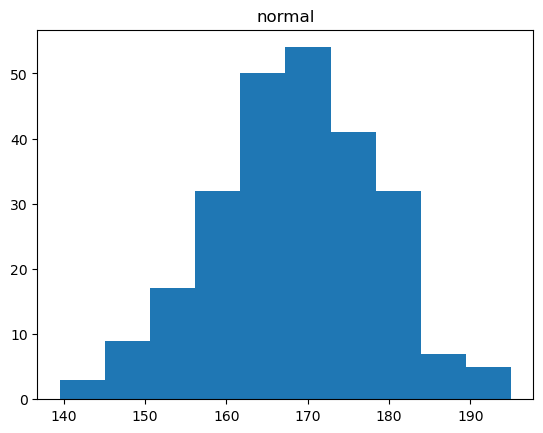

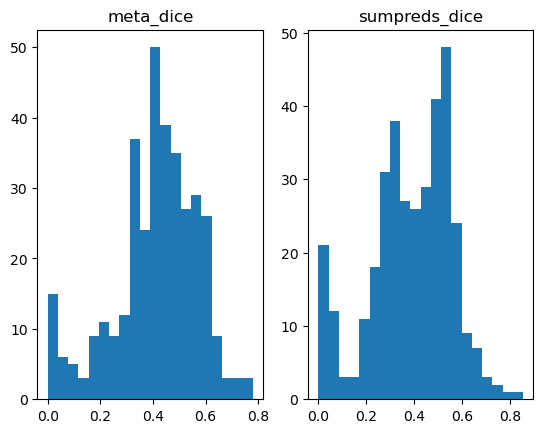

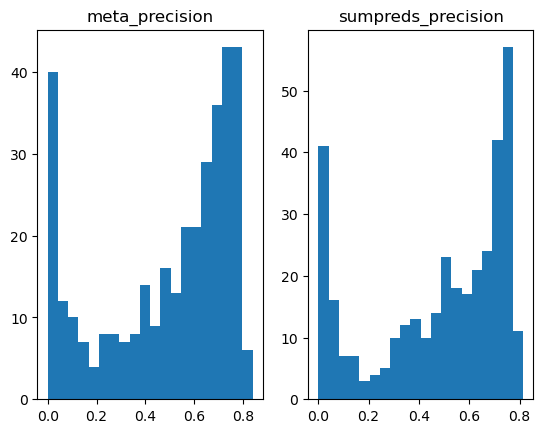

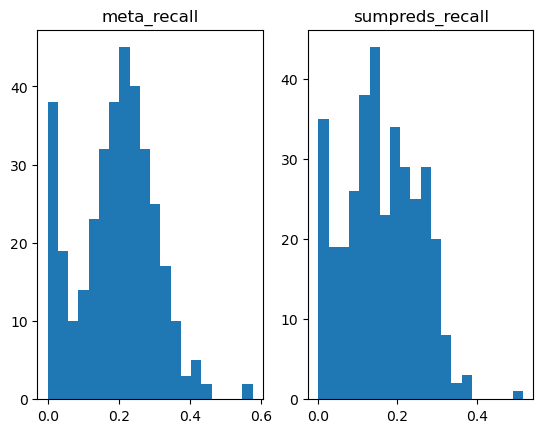

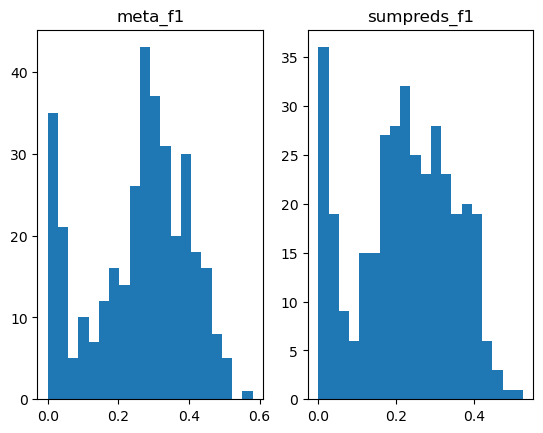

In [68]:
# do the metrics have a Gaussian distribution?

# this is a Gaussian
plt.hist(np.random.normal(170,10, 250))
plt.title('normal')
plt.show()

plt.subplot(1,2,1)
plt.hist(meta_dice, bins=20)
plt.title('meta_dice')
plt.subplot(1,2,2)
plt.hist(sumpreds_dice, bins=20)
plt.title('sumpreds_dice')
plt.show()

plt.subplot(1,2,1)
plt.hist(meta_precision, bins=20)
plt.title('meta_precision')
plt.subplot(1,2,2)
plt.hist(sumpreds_precision, bins=20)
plt.title('sumpreds_precision')
plt.show()

plt.subplot(1,2,1)
plt.hist(meta_recall, bins=20)
plt.title('meta_recall')
plt.subplot(1,2,2)
plt.hist(sumpreds_recall, bins=20)
plt.title('sumpreds_recall')
plt.show()

plt.subplot(1,2,1)
plt.hist(meta_f1, bins=20)
plt.title('meta_f1')
plt.subplot(1,2,2)
plt.hist(sumpreds_f1, bins=20)
plt.title('sumpreds_f1')
plt.show()

(0.40995428859212146, 0.387793661562175)

In [17]:
# do the metrics have a Gaussian distribution?

shapiro_meta_dice = scipy.stats.shapiro(meta_dice)
shapiro_sumpreds_dice = scipy.stats.shapiro(sumpreds_dice)
shapiro_meta_precision = scipy.stats.shapiro(meta_precision)
shapiro_sumpreds_precision = scipy.stats.shapiro(sumpreds_precision)
shapiro_meta_recall = scipy.stats.shapiro(meta_recall)
shapiro_sumpreds_recall = scipy.stats.shapiro(sumpreds_recall)
shapiro_meta_f1 = scipy.stats.shapiro(meta_f1)
shapiro_sumpreds_f1 = scipy.stats.shapiro(sumpreds_f1)

print(f'shapiro test for dice meta         : {shapiro_meta_dice}')
print(f'shapiro test for dice sumpreds     : {shapiro_sumpreds_dice}')

print(f'shapiro test for precision meta    : {shapiro_meta_precision}')
print(f'shapiro test for precision sumpreds: {shapiro_sumpreds_precision}')

print(f'shapiro test for recall meta       : {shapiro_meta_recall}')
print(f'shapiro test for recall sumpreds   : {shapiro_sumpreds_recall}')

print(f'shapiro test for f1 meta           : {shapiro_meta_f1}')
print(f'shapiro test for f1 sumpreds       : {shapiro_sumpreds_f1}')

shapiro test for dice meta         : ShapiroResult(statistic=0.9588984847068787, pvalue=2.0275162881944198e-08)
shapiro test for dice sumpreds     : ShapiroResult(statistic=0.9624190926551819, pvalue=6.582074263405957e-08)
shapiro test for precision meta    : ShapiroResult(statistic=0.8640941977500916, pvalue=4.46366113821621e-17)
shapiro test for precision sumpreds: ShapiroResult(statistic=0.8699260950088501, pvalue=1.0655430292742273e-16)
shapiro test for recall meta       : ShapiroResult(statistic=0.972830057144165, pvalue=3.257100615883246e-06)
shapiro test for recall sumpreds   : ShapiroResult(statistic=0.9773094058036804, pvalue=2.2260315745370463e-05)
shapiro test for f1 meta           : ShapiroResult(statistic=0.9477265477180481, pvalue=6.917795225547252e-10)
shapiro test for f1 sumpreds       : ShapiroResult(statistic=0.9658883810043335, pvalue=2.2398349130980932e-07)


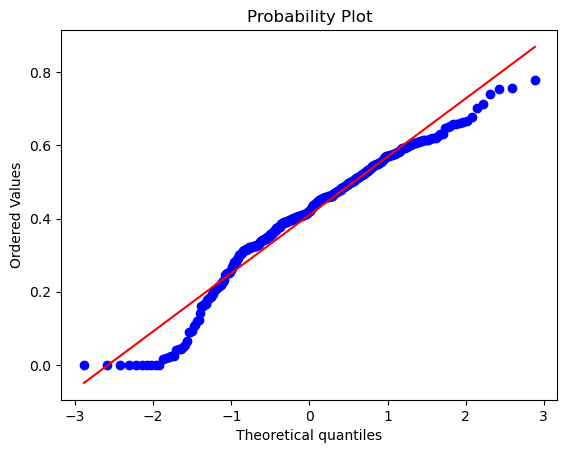

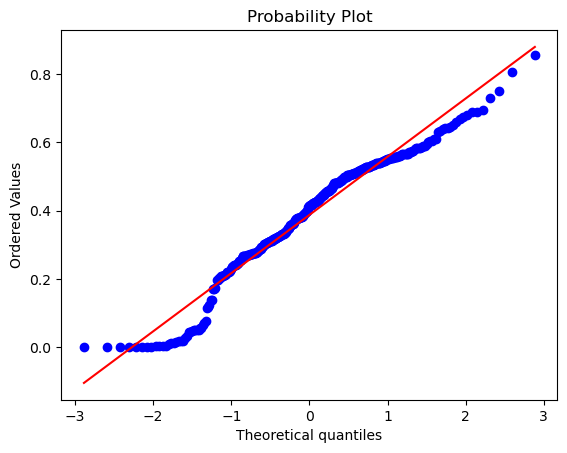

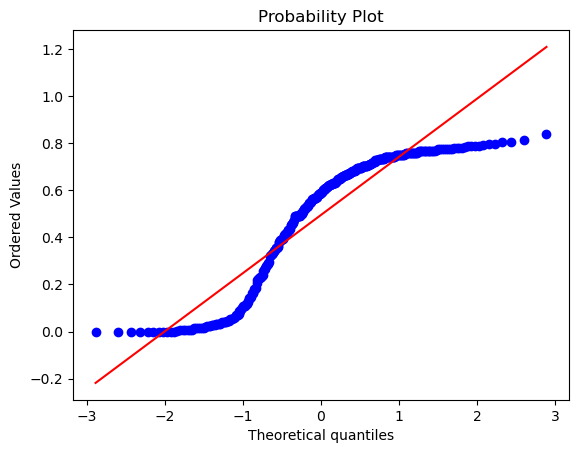

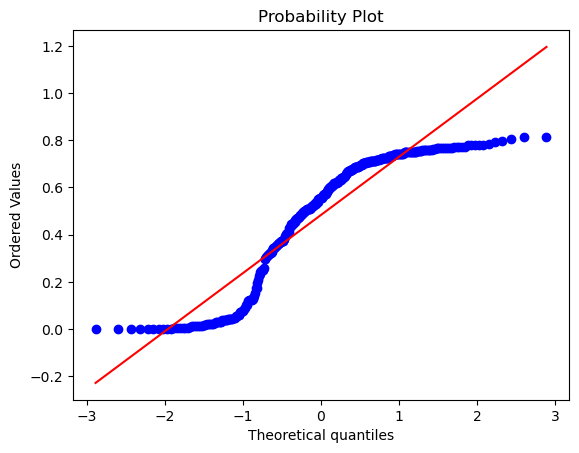

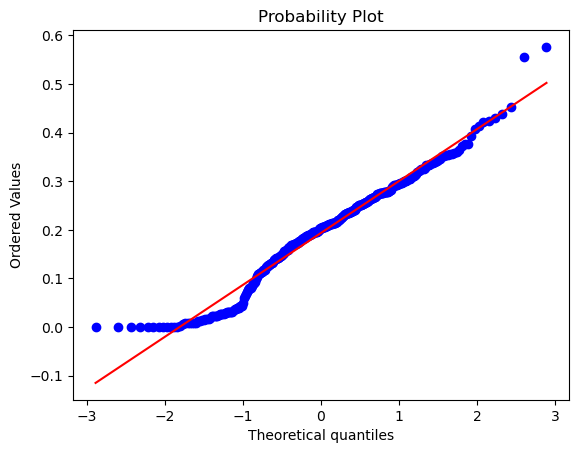

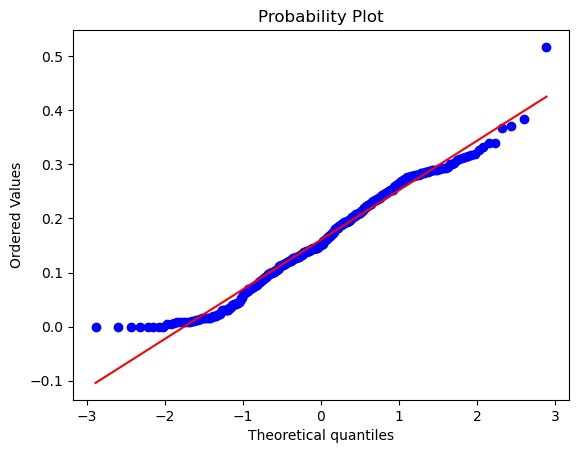

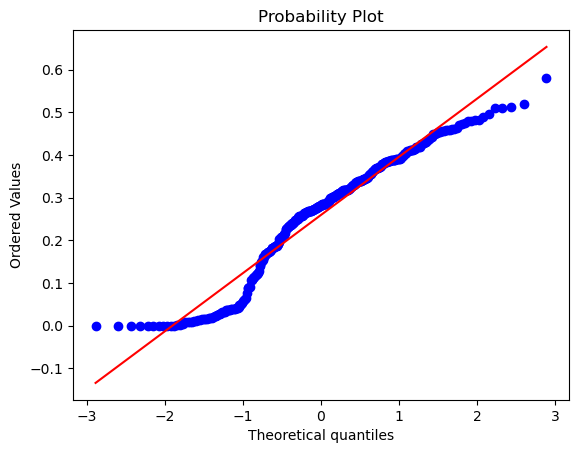

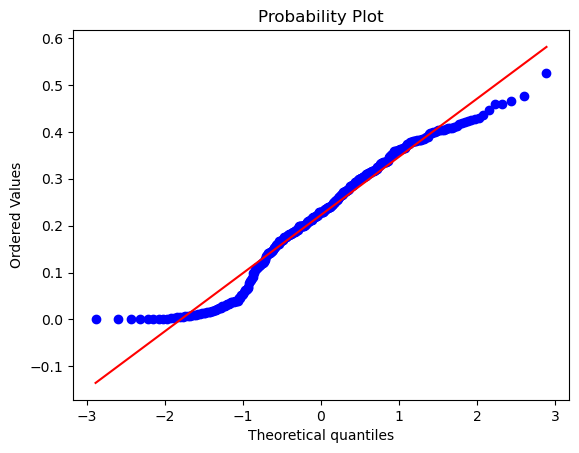

In [18]:
# do the metrics have a Gaussian distribution?
scipy.stats.probplot(meta_dice, dist='norm', fit=True, plot=plt)
plt.show()
scipy.stats.probplot(sumpreds_dice, dist='norm', fit=True, plot=plt)
plt.show()

scipy.stats.probplot(meta_precision, dist='norm', fit=True, plot=plt)
plt.show()
scipy.stats.probplot(sumpreds_precision, dist='norm', fit=True, plot=plt)
plt.show()

scipy.stats.probplot(meta_recall, dist='norm', fit=True, plot=plt)
plt.show()
scipy.stats.probplot(sumpreds_recall, dist='norm', fit=True, plot=plt)
plt.show()

scipy.stats.probplot(meta_f1, dist='norm', fit=True, plot=plt)
plt.show()
scipy.stats.probplot(sumpreds_f1, dist='norm', fit=True, plot=plt)
plt.show()

In [24]:
# t-statistic and p-values
# https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/?ref=ml_lbp
print(f'dice: {scipy.stats.ttest_rel(meta_dice, sumpreds_dice)}')
print(f'precision: {scipy.stats.ttest_rel(meta_precision, sumpreds_precision)}')
print(f'recall: {scipy.stats.ttest_rel(meta_recall, sumpreds_recall)}')
print(f'f1: {scipy.stats.ttest_rel(meta_f1, sumpreds_f1)}')

dice: Ttest_relResult(statistic=4.826411474204536, pvalue=2.0708064936974015e-06)
precision: Ttest_relResult(statistic=6.272507491080258, pvalue=1.036306580313429e-09)
recall: Ttest_relResult(statistic=14.099254872304256, pvalue=3.8693300791101226e-36)
f1: Ttest_relResult(statistic=14.705090821612849, pvalue=1.5386054865078562e-38)


In [66]:
if False:
    # cohen's d for paired samples (effect size)
    
    #dice_diff = np.diff((meta_dice, sumpreds_dice), axis=0)
    #precision_diff = np.diff((meta_precision, sumpreds_precision), axis=0)
    #recall_diff = np.diff((meta_recall, sumpreds_recall), axis=0)
    #f1_diff = np.diff((meta_f1, sumpreds_f1), axis=0)
    
    dice_cohen = ( np.mean(meta_dice) - np.mean(sumpreds_dice) ) / np.mean( (np.std(meta_dice, ddof=1), np.std(sumpreds_dice, ddof=1)) ) #np.mean(dice_diff) / np.std(dice_diff, ddof=1)
    precision_cohen = ( np.mean(meta_precision) - np.mean(sumpreds_precision) ) / np.mean( (np.std(meta_precision, ddof=1), np.std(sumpreds_precision, ddof=1)) ) #np.mean(precision_diff) / np.std(precision_diff, ddof=1)
    recall_cohen = ( np.mean(meta_recall) - np.mean(sumpreds_recall) ) / np.mean( (np.std(meta_recall, ddof=1), np.std(sumpreds_recall, ddof=1)) ) #np.mean(recall_diff) / np.std(recall_diff, ddof=1)
    f1_cohen = ( np.mean(meta_f1) - np.mean(sumpreds_f1) ) / np.mean( (np.std(meta_f1, ddof=1), np.std(sumpreds_f1, ddof=1)) ) #np.mean(f1_diff) / np.std(f1_diff, ddof=1)
    
    
    print(f'dice_cohen      : {dice_cohen}')
    print(f'precision_cohen : {precision_cohen}')
    print(f'recall_cohen    : {recall_cohen}')
    print(f'f1_cohen        : {f1_cohen}')
    
    print('dice means       :', "%.4f" % np.mean(meta_dice), ", %.4f" % np.mean(sumpreds_dice) , "  std1: %.4f" % np.std(meta_dice, ddof=1), "  std2: %.4f" % np.std(sumpreds_dice, ddof=1) )
    print('precision means  :', "%.4f" % np.mean(meta_precision), ", %.4f" % np.mean(sumpreds_dice) , "  std1: %.4f" % np.std(meta_precision, ddof=1), "  std2: %.4f" % np.std(sumpreds_precision, ddof=1) )
    print('recall means     :', "%.4f" % np.mean(meta_recall), ", %.4f" % np.mean(sumpreds_dice) , "  std1: %.4f" % np.std(meta_recall, ddof=1), "  std2: %.4f" % np.std(sumpreds_recall, ddof=1) )
    print('f1 means         :', "%.4f" % np.mean(meta_f1), ", %.4f" % np.mean(sumpreds_dice) , "  std1: %.4f" % np.std(meta_f1, ddof=1), "  std2: %.4f" % np.std(sumpreds_f1, ddof=1) )

dice_cohen      : 0.13265742801429933
precision_cohen : 0.04416510823621918
recall_cohen    : 0.33049179232053294
f1_cohen        : 0.2788548194990583
dice means       : 0.4100 , 0.3878   std1: 0.1616   std2: 0.1725
precision means  : 0.4952 , 0.3878   std1: 0.2638   std2: 0.2624
recall means     : 0.1936 , 0.3878   std1: 0.1077   std2: 0.0923
f1 means         : 0.2597 , 0.3878   std1: 0.1392   std2: 0.1254


In [ ]:
plt.subplot(2,2,1)
plt.plot(meta_dice, '.')
plt.plot(sumpreds_dice, 'r.')
plt.title('dice')

plt.subplot(2,2,2)
plt.plot(meta_precision, '.')
plt.plot(sumpreds_precision, 'r.')
plt.title('precision')

plt.subplot(2,2,3)
plt.plot(meta_recall, '.')
plt.plot(sumpreds_recall, 'r.')
plt.title('recall')

plt.subplot(2,2,4)
plt.plot(meta_f1, '.')
plt.plot(sumpreds_f1, 'r.')
plt.title('f1')
plt.show()

In [ ]:
print(f'meta mean    : {np.mean(meta_dice), np.average(meta_precision), np.mean(meta_recall), np.mean(meta_f1)}')
print(f'meta sd      : {np.std(meta_dice), np.std(meta_precision), np.std(meta_recall), np.std(meta_f1)}')

print(f'sumpreds mean: {np.mean(sumpreds_dice), np.average(sumpreds_precision), np.mean(sumpreds_recall), np.mean(sumpreds_f1)}')
print(f'sumpreds sd  : {np.std(sumpreds_dice), np.std(sumpreds_precision), np.std(sumpreds_recall), np.std(sumpreds_f1)}')


print(f'meta max     : {np.max(meta_dice), np.max(meta_precision), np.max(meta_recall), np.max(meta_f1)}')
print(f'meta min     : {np.min(meta_dice), np.min(meta_precision), np.min(meta_recall), np.min(meta_f1)}')

print(f'sumpreds max : {np.max(sumpreds_dice), np.max(sumpreds_precision), np.max(sumpreds_recall), np.max(sumpreds_f1)}')
print(f'sumpreds min : {np.min(sumpreds_dice), np.min(sumpreds_precision), np.min(sumpreds_recall), np.min(sumpreds_f1)}')

In [ ]:
image = np.asanyarray(Image.open('/disk/k_raid/DATA/SHIMOGORI_P0/data/image/LRRN3_P0_184-2/026.png'))
label = np.asanyarray(Image.open('/disk/k_raid/DATA/SHIMOGORI_P0/data/label/LRRN3_P0_184-2/LRRN3_P0_184-2-09_3_27.png'))
ensemble = np.asanyarray(Image.open('/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/out/20240403_nonew_testset_ensemble/LRRN3_P0_184-2_026.png'))
meta = np.asanyarray(Image.open('/home/charissa/shimogori/shimogori_adult/segmentation/meta_net/out/20240403_nonew_testset_metanet/LRRN3_P0_184-2_026.png'))

char0= np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202308_charunet3d/20230816_charunet_3d_diceloss_epochs_800_fold_0/LRRN3_P0_184-2/026.png'))
char1= np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202308_charunet3d/20230816_charunet_3d_diceloss_epochs_800_fold_1/LRRN3_P0_184-2/026.png'))
char2= np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202308_charunet3d/20230817_charunet_3d_diceloss_epochs_800_fold_2/LRRN3_P0_184-2/026.png'))
char3= np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202308_charunet3d/20230817_charunet_3d_diceloss_epochs_800_fold_3/LRRN3_P0_184-2/026.png'))
char4= np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202308_charunet3d/20230817_charunet_3d_diceloss_epochs_800_fold_4/LRRN3_P0_184-2/026.png'))

swin2d0 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr2d/20231113_swinunetr_2d_diceloss_epochs_300_fold_0/LRRN3_P0_184-2/026.png'))
swin2d1 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr2d/20231113_swinunetr_2d_diceloss_epochs_300_fold_1/LRRN3_P0_184-2/026.png'))
swin2d2 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr2d/20231113_swinunetr_2d_diceloss_epochs_300_fold_2/LRRN3_P0_184-2/026.png'))
swin2d3 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr2d/20231114_swinunetr_2d_diceloss_epochs_300_fold_3/LRRN3_P0_184-2/026.png'))
swin2d4 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr2d/20231114_swinunetr_2d_diceloss_epochs_300_fold_4/LRRN3_P0_184-2/026.png'))

swin3d0 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231115_swinunetr_3d_diceloss_epochs_300_fold_0/LRRN3_P0_184-2/026.png'))
swin3d1 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231115_swinunetr_3d_diceloss_epochs_300_fold_1/LRRN3_P0_184-2/026.png'))
swin3d2 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231116_swinunetr_3d_diceloss_epochs_300_fold_2/LRRN3_P0_184-2/026.png'))
swin3d3 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231116_swinunetr_3d_diceloss_epochs_300_fold_3/LRRN3_P0_184-2/026.png'))
swin3d4 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_swinunetr3d/20231117_swinunetr_3d_diceloss_epochs_300_fold_4/LRRN3_P0_184-2/026.png'))

unet2d0 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet2d/20231110_unet2d_diceloss_epochs_300_fold_0/LRRN3_P0_184-2/026.png'))
unet2d1 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet2d/20231110_unet2d_diceloss_epochs_300_fold_1/LRRN3_P0_184-2/026.png'))
unet2d2 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet2d/20231110_unet2d_diceloss_epochs_300_fold_2/LRRN3_P0_184-2/026.png'))
unet2d3 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet2d/20231110_unet2d_diceloss_epochs_300_fold_3/LRRN3_P0_184-2/026.png'))
unet2d4 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet2d/20231110_unet2d_diceloss_epochs_300_fold_4/LRRN3_P0_184-2/026.png'))

unet3d0 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet3d/20231115_unet3d_diceloss_epochs_300_fold_0/LRRN3_P0_184-2/026.png'))
unet3d1 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet3d/20231115_unet3d_diceloss_epochs_300_fold_1/LRRN3_P0_184-2/026.png'))
unet3d2 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet3d/20231116_unet3d_diceloss_epochs_300_fold_2/LRRN3_P0_184-2/026.png'))
unet3d3 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet3d/20231116_unet3d_diceloss_epochs_300_fold_3/LRRN3_P0_184-2/026.png'))
unet3d4 = np.asanyarray(Image.open('/disk/charissa/ISH_reg_pipeline/segs/P0_segs/202311_unet3d/20231117_unet3d_diceloss_epochs_300_fold_4/LRRN3_P0_184-2/026.png'))

In [ ]:
plt.subplot(1,29,1)
plt.imshow(image[:,image.shape[1]//2:,:])
plt.axis('off')
plt.subplot(1,29,2)
plt.imshow(label[:,label.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,3)
plt.imshow(ensemble, cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,4)
plt.imshow(meta, cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,5)
plt.imshow(char0[:,char0.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,6)
plt.imshow(char1[:,char0.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,7)
plt.imshow(char2[:,char0.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,8)
plt.imshow(char3[:,char0.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,9)
plt.imshow(char4[:,char0.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,10)
plt.imshow(swin2d0[:,swin2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,11)
plt.imshow(swin2d1[:,swin2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,12)
plt.imshow(swin2d2[:,swin2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,13)
plt.imshow(swin2d3[:,swin2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,14)
plt.imshow(swin2d4[:,swin2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,15)
plt.imshow(swin3d0[:,swin3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,16)
plt.imshow(swin3d1[:,swin3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,17)
plt.imshow(swin3d2[:,swin3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,18)
plt.imshow(swin3d3[:,swin3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,19)
plt.imshow(swin3d4[:,swin3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,20)
plt.imshow(unet2d0[:,unet2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,21)
plt.imshow(unet2d1[:,unet2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,22)
plt.imshow(unet2d2[:,unet2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,23)
plt.imshow(unet2d3[:,unet2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,24)
plt.imshow(unet2d4[:,unet2d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.subplot(1,29,25)
plt.imshow(unet3d0[:,unet3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,26)
plt.imshow(unet3d1[:,unet3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,27)
plt.imshow(unet3d2[:,unet3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,28)
plt.imshow(unet3d3[:,unet3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')
plt.subplot(1,29,29)
plt.imshow(unet3d4[:,unet3d4.shape[1]//2:], cmap='Greys_r')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for d, data in enumerate(test_loader):
    print(d, data[2])
    

In [ ]:
unet3d4[:,unet3d4.shape[1]//2:].shape

In [ ]:
seg = resize(seg, (256, 128))

seg = seg.astype('float32')
seg /= 255

In [ ]:


x,y,n = test_loader.dataset[146]
#inputs = inputs.unsqueeze(0)
#labels = labels.unsqueeze(0)

########### find the segs ###########
seg_idirs = find_segs(n, seg_paths_all)
seg_all = load_segs(seg_idirs)              # (torch.Size([1, 25, 256, 128]), torch.float32)
####################################

##### run meta_unet #####
yhat, yhat_weights = meta_model(torch.unsqueeze(x,dim=0), seg_all)
#yhat = post_pred(yhat)

##### make numpy versions, ensure shapes, dtypes, are the same #####
y_np = torch.squeeze(y.detach().cpu()).numpy()
yhat_np = torch.squeeze(yhat.detach().cpu()).numpy()


# threshold, done on numpys
thresh_meta = threshold_otsu(yhat_np)
yhat_np = (yhat_np > thresh_meta)*1
yhat_np = yhat_np.astype(np.float32)


##### make sum of all preds #####
# all_preds should be tensor of form e.g. torch.Size([1, 25, 512, 512])
preds_sum = torch.zeros((seg_all[0,0].shape))
for i in range(seg_all.shape[1]):
    preds_sum += seg_all.detach().cpu()[0,i]
preds_sum /= seg_all.shape[1]
# threshold, done on numpys
thresh_sum = threshold_otsu(preds_sum.numpy())
preds_sum_01 = (preds_sum > thresh_sum)*1
preds_sum_01 = preds_sum_01.type(torch.float32)  # has to be kept a Tensor for dice calculation
preds_sum_01_np = preds_sum_01.detach().cpu().numpy()

In [ ]:
x.shape, y.shape, yhat.shape, preds_sum_01_np.shape

In [ ]:
#plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["figure.figsize"] = (10,6)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


#divisor = 5


num_rows = 4#seg_all.shape[1]+4
num_cols = 1#1

plt.subplot(num_cols,num_rows,1)
plt.imshow(torch.permute(x,(1,2,0)).clone().cpu().detach().numpy())
#plt.title('image')
plt.axis('off')

plt.subplot(num_cols,num_rows,2)
plt.imshow(y[0,...].clone().cpu().detach().numpy())
#plt.title('ground truth')
plt.axis('off')

plt.subplot(num_cols,num_rows,3)
plt.imshow(yhat[0,0,...].clone().cpu().detach().numpy())
#plt.title('meta')
plt.axis('off')

plt.subplot(num_cols,num_rows,4)
plt.imshow(preds_sum_01_np)
#plt.title('ensemble')
plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
#plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["figure.figsize"] = (14,4)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


#divisor = 5


num_rows = 13#seg_all.shape[1]//2 +1
num_cols = 2#2#1

for i in range(seg_all.shape[1]):    
    plt.subplot(num_cols,num_rows,i+1)
    plt.imshow(seg_all[0,i].clone().cpu().detach().numpy(), cmap='Greys_r')
    #plt.title(f"pred{str(i-4)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#########################################
############ TROUBLESHOOTING ############
#########################################


in_channels = num_models + 1  # add 1 channel for the image

if len(x.shape) == 2:     # no channels, for whatever reason
    im_seg_size = x.shape[0] * x.shape[1] * in_channels
elif len(x.shape) == 3 or len(x.shape) == 4:                         # if C, C always 1 after conv2d_im ; or C andd B
    im_seg_size = x.shape[-1] * x.shape[-2] * in_channels  # segs should have C=1
else:
    print('error')
#print(f'in init, im_seg_size: {self.im_seg_size} from im_shape {im_shape}')        




conv2d_im = nn.Conv2d(3, 1, kernel_size=(3,3), stride=(1,1), padding=(1,1))
#self.conv_down1 = convbnrelu_im_33(self.in_channels, init_features)

## ENCODER
#init_features=16            
maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
#self.conv_down1 = convbnrelu_im_33(in_channels, init_features)
conv_down1 = convbnrelu_im_33(in_channels, init_features)
conv_down2 = convbnrelu_im_33(init_features, init_features*2)
conv_down3 = convbnrelu_im_33(init_features*2, init_features*4)
conv_down4 = convbnrelu_im_33(init_features*4, init_features*8)
bottleneck = convbnrelu_im_33(init_features*8, init_features*16)

## DECODER
convT4 = nn.ConvTranspose2d(init_features*16, init_features*8, kernel_size=(2,2), stride=(2,2))##bn this
conv_up4 = convbnrelu_im_33((init_features*8)*2, init_features*8)
convT3 = nn.ConvTranspose2d(init_features*8, init_features*4, kernel_size=(2,2), stride=(2,2))##bn this
conv_up3 = convbnrelu_im_33((init_features*4)*2, init_features*4)
convT2 = nn.ConvTranspose2d(init_features*4, init_features*2, kernel_size=(2,2), stride=(2,2))##bn this
conv_up2 = convbnrelu_im_33((init_features*2)*2, init_features*2)
convT1 = nn.ConvTranspose2d(init_features*2, init_features, kernel_size=(2,2), stride=(2,2))##bn this
conv_up1 = convbnrelu_im_33(init_features*2, init_features)
conv_up0 = convbnrelu_im_33(init_features, in_channels)


## PREPARE IMAGE AND SEGS
x = x.to('cpu')
x2 = conv2d_im(x)
seg_idirs = find_segs(n[0], seg_paths_all)
segs_ = load_segs(seg_idirs)
segs_ = segs_.to('cpu')

# ENCODE
x_preds = torch.cat((x2, segs_), dim=1)
enc1 = conv_down1(x_preds)
enc2 = conv_down2(maxpool(enc1))
enc3 = conv_down3(maxpool(enc2))
enc4 = conv_down4(maxpool(enc3))
bottle = bottleneck(maxpool(enc4))
print('x    {}\nx_preds {}\nenc2 {}\nenc3 {}\nenc4 {}\nbottle {}'.format(x.shape, x_preds.shape, enc1.shape, enc2.shape, enc3.shape, enc4.shape, bottle.shape))

# DECODE
dec4 = convT4(bottle)  
dec4 = torch.cat([dec4, enc4], dim=1)
dec4 = conv_up4(dec4)       
dec3 = convT3(dec4)
dec3 = torch.cat([dec3, enc3], dim=1)
dec3 = conv_up3(dec3)                     # torch.Size([1, 64, 128, 128])
dec2 = convT2(dec3)
dec2 = torch.cat([dec2, enc2], dim=1)
dec2 = conv_up2(dec2)                     # torch.Size([1, 32, 256, 256])
dec1 = convT1(dec2)
dec1 = torch.cat([dec1, enc1], dim=1)
dec1 = conv_up1(dec1)                     # torch.Size([1, 16, 512, 512])
out = conv_up0(dec1)                      # torch.Size([1, 11, 512, 512])

#out = torch.sigmoid(out)
#out = torch.tanh(out)

print('dec4 {}\ndec3 {}\ndec2 {}\ndec1 {}\nout {}'.format(dec4.shape, dec3.shape, dec2.shape, dec1.shape, out.shape))



#out = torch.sigmoid(out)
print(f'pre-activation out:  {out.shape, out.max().item(), out.min().item()}')
out = torch.tanh(out)
print(f'post-activation out: {out.shape, out.max().item(), out.min().item()}')
out_flat = torch.flatten(out, start_dim=2, end_dim=3)  # torch.Size([1, 10, 262144])
print(f"out_flat:            {out_flat.shape, out_flat.max().item(), out_flat.min().item(), out_flat.dtype}")

seg_sum = torch.zeros((x.shape[-2] * x.shape[-1]))
for i in range(out_flat.shape[-1]):
    seg_sum[i] = torch.sum(out_flat[0,:,i])/num_models
# reshape into the original image shape
seg_sum = torch.reshape(seg_sum, (x.shape[-2], x.shape[-1]))
seg_sum_sigmoid = torch.sigmoid(seg_sum)

print(f'seg_sum_sigmoid:     {seg_sum_sigmoid.shape, seg_sum_sigmoid.dtype, seg_sum_sigmoid.max(), seg_sum_sigmoid.min()}')

In [ ]:
plt.subplot(1,3,1)
plt.imshow(torch.permute(x[0], (1,2,0)))
plt.subplot(1,3,2)
plt.imshow(y.detach().cpu()[0,0])
plt.subplot(1,3,3)
#plt.imshow(out.detach().cpu()[0,0])
plt.imshow(seg_sum_sigmoid.detach().cpu())
plt.show()

In [ ]:
out.shape, out.dtype, out.max(), out.min()

In [ ]:
import torch.nn.functional as F

class Meta_D2(nn.Module):
    def __init__(self, im_shape, num_models):
        super(Meta_D2, self).__init__()

        self.num_models = num_models  #786432  # 1*3*512*512
        self.in_channels = self.num_models + 1  # add 1 channel for the image

        if len(im_shape) == 2:     # no channels, for whatever reason
            print(f'ERROR likely for im_shape {im_shape} resulting in {self.im_seg_size}')
            self.im_seg_size = im_shape[0] * im_shape[1] * self.in_channels
        elif len(im_shape) == 3 or len(im_shape) == 4:                         # if C, C always 1 after conv2d_im ; or C andd B
            self.im_seg_size = im_shape[-1] * im_shape[-2] * self.in_channels  # segs should have C=1
        else:
            print('error')
        #print(f'in init, im_seg_size: {self.im_seg_size} from im_shape {im_shape}')        
        
        


        self.conv2d_im = nn.Conv2d(3, 1, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        #self.conv_down1 = convbnrelu_im_33(self.in_channels, init_features)
        
        if False:
            self.hidden_size = 128
            #self.fc1 = nn.Linear(self.im_size * self.num_models, self.hidden_size)
            self.fc1 = nn.Linear(self.im_seg_size, self.hidden_size)
            self.fc2 = nn.Linear(self.hidden_size, self.hidden_size*2)
            self.fc3 = nn.Linear(self.hidden_size*2, self.im_seg_size)

        self.init_features=16            
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #self.conv_down1 = convbnrelu_im_33(in_channels, init_features)
        self.conv_down1 = convbnrelu_im_33(self.in_channels, self.init_features)
        self.conv_down2 = convbnrelu_im_33(self.init_features, self.init_features*2)
        self.conv_down3 = convbnrelu_im_33(self.init_features*2, self.init_features*4)
        self.conv_down4 = convbnrelu_im_33(self.init_features*4, self.init_features*8)
        self.bottleneck = convbnrelu_im_33(self.init_features*8, self.init_features*16)
        

        # do i need dropout layers
        self.dropout1 = nn.Dropout(0.25)

        

        

    def forward(self, x, yhat_all):
        
        # print(f'in forward, x before conv2d_im: {x.shape}')
        # reduce x from 3,512,512 to 1,512,512 which matches preds
        x = self.conv2d_im(x)

        # concat x and preds stack
        x_preds = torch.cat((x, yhat_all), dim=1)
        print(f'in forward, x: {x.shape}, yhat_all: {yhat_all.shape}, x_preds: {x_preds.shape}')

        # values for 3,512,512 im input and 1,512,512 preds                                                   
        enc1 = self.conv_down1(x_preds)               # torch.Size([1, 16, 512, 512])
        enc2 = self.conv_down2(self.maxpool(enc1))    # torch.Size([1, 32, 256, 256])
        enc3 = self.conv_down3(self.maxpool(enc2))    # torch.Size([1, 64, 128, 128])
        enc4 = self.conv_down4(self.maxpool(enc3))    # torch.Size([1, 128, 64, 64])
        
        bottle = self.bottleneck(self.maxpool(enc4))  # torch.Size([1, 256, 32, 32])

        #bottle = torch.tanh(bottle)

        print(f'enc1:{enc1.shape},  enc2:{enc2.shape},  enc3:{enc3.shape},  enc4:{enc4.shape},  bottle:{bottle.shape}')

        if False:
            # apply softmax
            #weights = F.tanh(yhat_combined)
            weights = F.sigmoid(yhat_combined)
    
    
            # dot product of the weights and predictions
            running_sum = 0
            for i in range(len(weights)):
                product = weights[i]*yhat_all[0,i]
                running_sum += product
            out = running_sum/self.num_models
    
            out = torch.sigmoid(out)
    
            return out, weights

        return bottle

In [ ]:
import torch.nn.functional as F

class Meta_D(nn.Module):
    def __init__(self, im_shape, num_models):
        super(Meta_D, self).__init__()

        self.num_models = num_models  #786432  # 1*3*512*512
        self.in_channels = self.num_models + 1  # add 1 channel for the image

        if len(im_shape) == 2:     # no channels, for whatever reason
            print(f'ERROR likely for im_shape {im_shape} resulting in {self.im_seg_size}')
            self.im_seg_size = im_shape[0] * im_shape[1] * self.in_channels
        elif len(im_shape) == 3 or len(im_shape) == 4:                         # if C, C always 1 after conv2d_im ; or C andd B
            self.im_seg_size = im_shape[-1] * im_shape[-2] * self.in_channels  # segs should have C=1
        else:
            print('error')
        #print(f'in init, im_seg_size: {self.im_seg_size} from im_shape {im_shape}')        
        
        self.hidden_size = 128


        self.conv2d_im = nn.Conv2d(3, 1, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        #self.conv_down1 = convbnrelu_im_33(self.in_channels, init_features)
        
        #self.fc1 = nn.Linear(self.im_size * self.num_models, self.hidden_size)
        self.fc1 = nn.Linear(self.im_seg_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_models)

        # do i need dropout layers
        self.dropout1 = nn.Dropout(0.25)

        

        

    def forward(self, x, yhat_all):
        
        # print(f'in forward, x before conv2d_im: {x.shape}')
        # reduce x from 3,512,512 to 1,512,512 which matches preds
        x = self.conv2d_im(x)

        # concat x and preds stack
        x_preds = torch.cat((x, yhat_all), dim=1)
        #print(f'in forward, x: {x.shape}, yhat_all: {yhat_all.shape}, x_preds: {x_preds.shape}')

        #enc1 = self.conv_down1(x_preds)

        
        #yhat_combined = torch.flatten(yhat_all, 0)
        yhat_combined = torch.flatten(x_preds, 0)
        #print(f'yhat_combined: {yhat_combined.shape}')
        yhat_combined = self.fc1(yhat_combined)
        yhat_combined = F.relu(yhat_combined)
        #yhat_combined = self.dropout1(yhat_combined)
        yhat_combined = self.fc2(yhat_combined)

        # apply softmax
        #weights = F.tanh(yhat_combined)
        weights = F.sigmoid(yhat_combined)


        # dot product of the weights and predictions
        running_sum = 0
        for i in range(len(weights)):
            product = weights[i]*yhat_all[0,i]
            running_sum += product
        out = running_sum/self.num_models

        out = torch.sigmoid(out)

        return out, weights

In [ ]:
## finding the relevant segmentations 1
if False:
    x,y,n = next(iter(train_loader))#batch_data[0].to(device), batch_data[1].to(device) 
    print(f'x: {x.shape}, y: {y.shape}, name: {n[0]}')
    if False:
        # 1 find the P0 cmp and corresponding z
        cmp = [x for x in n[0].split('/') if 'P0_' in x][0]
        z = [x for x in n[0].split('/') if '.png' in x][0]
        
        cmp, z
        
        # 2 find the p0 cmp's matching segmentation dirs
        if cmp in [x for x in os.listdir(seg_paths_all[0])]:  # does not matter what the index of seg_paths_all should be
            seg_idirs_4_cmp_z = []
            for i in seg_paths_all: 
                if os.path.exists(i+cmp):
                    #seg_idir = i+p0_id+'/'
                    seg_dir = i+cmp+'/'+z
                    seg_idirs_4_cmp_z.append(seg_dir)
                else:
                    print(f'no matching seg idir for {i} and {cmp}')
        
        else:
            print(f'no {p0_id} in segmentations {os.listdir(seg_paths_all[0])}')
            
        print(f'number of segmentations + eg: {len(seg_idirs_4_cmp_z)}\n{seg_idirs_4_cmp_z[2]}\n{seg_idirs_4_cmp_z[6]}')


In [ ]:
## 3 load and show the relevant SEGS ##
if False:
    ttt = transforms.ToTensor()
    
    for k in range(len(seg_idirs_4_cmp_z)):
        
        seg = np.asarray(Image.open(seg_idirs_4_cmp_z[k]))
        
        
        half = int(seg.shape[1]/2)
        seg = seg[:,half:]
    
        # downsize the segmentations as the images and labels were downsized
        #seg = resize(seg, (1024, 512))
        seg = resize(seg, (512, 256))
        
        seg = seg.astype('float32')
        seg /= 255
    
        # ensure that seg.max() == 1 if there is something in the image
        #if seg.max() > 0.3:
        #    seg = seg*1/seg.max()
    
        seg = ttt(seg)
        
        if k==0:
            seg_all = torch.zeros((len(seg_idirs_4_cmp_z), seg.shape[1], seg.shape[2]))
        
        #print(seg.dtype, seg.max(), seg.shape)#, np.unique(seg))
    
        seg_all[k] = seg[0]
    
        if False:
            #plt.subplot(1,len(seg_idirs_4_cmp),k+1)
            plt.imshow(seg[0], vmin=0, vmax=1)
            plt.title(f[k].split('/')[-3])
            plt.show()
    
    # if seg_all.max() values are way below 1
    if seg_all.max() < 0.999:
        seg_all = seg_all*1/seg_all.max()
    seg_all = torch.unsqueeze(seg_all, dim=0)

In [ ]:
# check by loading the segmentations in seg_idirs_4_cmp_z
if False:
    seg = np.asarray(Image.open(seg_idirs_4_cmp_z[0]))
    seg.shape
    plt.subplot(1,2,1)
    plt.imshow(x[0,0], vmin=0, vmax=1)
    plt.title('x')
    plt.subplot(1,2,2)
    plt.imshow(seg_all[0,0])
    plt.title('seg_all[0,0]')
    plt.show()

In [ ]:
# scale seg_all if the values are way below 1
if False:
    print(seg_all.shape, seg_all.max(), seg_all.dtype)
    seg_all2 = seg_all*1/seg_all.max()
    print(seg_all2.shape, seg_all2.max(), seg_all2.min(), seg_all2.dtype)
    np.unique(seg_all2)

In [ ]:
# checking the loaded segmentations
if False:
    print(np.array_equal(seg_all[0,5], seg_all[0,0]))
    print(f'seg_all: {seg_all.shape}, x: {x.shape}, y: {y.shape}')
    for h in range(0,seg_all.shape[1]):
        plt.subplot(1,4,1)
        plt.imshow(torch.permute(x.cpu()[0],(1,2,0)))
        plt.title('x')
        plt.subplot(1,4,2)
        plt.imshow(y[0,0])
        plt.title('y')
        plt.subplot(1,4,3)
        plt.imshow(seg_all.cpu()[0,h], vmin=0, vmax=1)
        plt.title('seg '+str(h))
        plt.subplot(1,4,4)
        plt.imshow(torch.permute(x[0],(1,2,0)))
        plt.imshow(seg_all.cpu()[0,h], alpha=0.3)
        plt.title('seg '+str(h))
        plt.show()
        print(f'seg: {seg_all.cpu()[0,h].max(), seg_all.cpu()[0,h].min(), seg_all.cpu()[0,h].dtype}')
        print(f'y:   {y[0,0].max(), y[0,0].min(), y[0,0].dtype}')

In [ ]:
x.shape, y.shape, seg_all.shape, num_models